## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from graphviz import Digraph
%matplotlib inline

## Defining graph for visualisation

In [2]:
def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular record node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Defining the Value class

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # Only supporting int and float powers for now
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * ( self.data ** (other - 1) ) * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t **2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(o)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

## Setting out and visualising the neuron

In [4]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label='o'

o.backward()

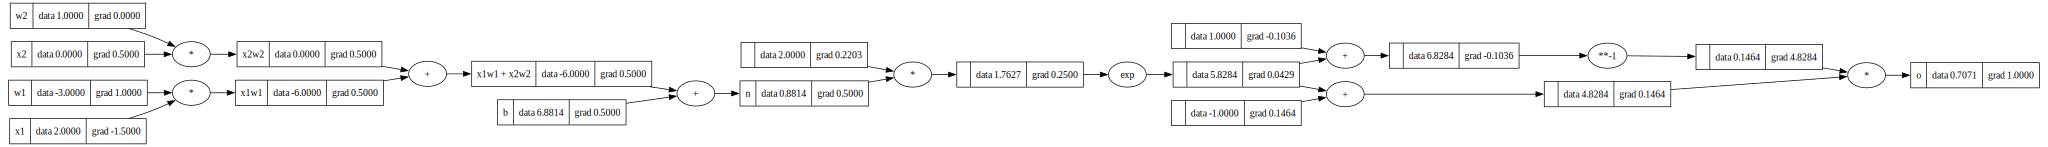

In [5]:
draw_dot(o)

## PyTorch implementation

In [6]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [16]:
x = [2.0, 3.0, -1.0]
n = MLP(2, [4, 4, 1])
n(x)

Value(data=0.822533418828556)

In [20]:
len(n.parameters())

37

In [21]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0], 
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets 

ypred = [n(x) for x in xs]
ypred

[Value(data=0.822533418828556),
 Value(data=0.9539619182248655),
 Value(data=0.8651691032844523),
 Value(data=0.8697084382974869)]

In [22]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.031494387432680716),
 Value(data=3.817967177872996),
 Value(data=3.478855783846928),
 Value(data=0.01697589105087978)]

In [23]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.3452932402034845)

In [24]:
type(loss)

__main__.Value

In [25]:
loss.backward()

AttributeError: 'Tensor' object has no attribute '_prev'

In [26]:
n.layers[0].neurons[0].w[0].grad

0.0

In [27]:
n.layers[0].neurons[0].w[0]

Value(data=0.27432718636325126)

In [ ]:
draw_dot(loss)

In [ ]:
for p in n.parameters():
    p.data += 